## Dataset Prueba 1 - Tesis Javier-Uriel

### Importamos algunas librerías que nos serán útiles más adelante

In [1]:
import os
import time
import random

import pandas as pd # for dataframe operations. 
import numpy as np #for linear algebra operations.
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # for plotting

from scipy.fftpack import fft, fftfreq

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

pd.set_option('display.max_columns', None) #Para mostrar todas las columnas
random.seed(1)

### Leemos el Dataset

In [2]:
#Dataset solo movimientos en Z
#rpm_list = ['RPM0', 'RPM1', 'RPM2', 'RPM3']
#states_list_org = ["vz","az", "uvz", 
#                    "p", "q",
#                    "wp", "wq", 
#                    "ap", "aq"]
rpm_list = ['Motor1', 'Motor2', 'Motor3', 'Motor4']
states_list_org = ["Z","Dz", "Z_r", "Ac_Dz",
                    "Yaw", "Roll",
                    "P", "Q", 
                    "Acceleracion P", "Acceleracion Q"]
#states_list_org = ["vz","az", "uvz"]
states_list_min = ["vz","az", "uvz"]
dataset_name = "Dataset_Z_Matlab"
directory = "../logs/Datasets/"+dataset_name
ORDER = 3
dfs = []
states_list=states_list_org.copy()

### Corregir la salida 
El estado que entrega Pybullet de RPMs es la salida anterior, en este dataset se tomará RPMs como la salida actual. Si el primer elemento de RPMs es 0, es necesario hacer el shift

In [3]:
for filename in os.listdir(directory):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(directory, filename))
    #if any(df['z']<=1) or any(abs(df['vz'])>=10): #Eliminar si el dron se cae
    #    print(filename)
    #else:
    if any(df[rpm_list].loc[0]==0): #Desplazar los estados de RPM si es necesario
        df[rpm_list] = df[rpm_list].shift(periods=-1)
        df = df.dropna()
        df.to_csv(os.path.join(directory, filename), index=False)

    a = []
    ## Desplazamos estados anteriores        
    for n in range(1,ORDER+1):
        for column in states_list:
            df[column+str(n)] = df[column].shift(periods=n, fill_value=0)
            a.append(column+str(n))
    dfs.append(df)
states_list+=a        
        
dataset = pd.concat(dfs)
dataset.describe()

,Time,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,Motor1,Motor2,Motor3,Motor4,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,P_r,Q_r,R_r,Flag_Pitch_Roll,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Bat_V,Bat_Percentage,Acceleracion X,Acceleracion Y,Acceleracion Z,Acceleracion P,Acceleracion Q,Acceleracion R,Z1,Dz1,Z_r1,Ac_Dz1,Yaw1,Roll1,P1,Q1,Acceleracion P1,Acceleracion Q1,Z2,Dz2,Z_r2,Ac_Dz2,Yaw2,Roll2,P2,Q2,Acceleracion P2,Acceleracion Q2,Z3,Dz3,Z_r3,Ac_Dz3,Yaw3,Roll3,P3,Q3,Acceleracion P3,Acceleracion Q3
count,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1295895.0,1295895.0,1.295895e+06,1295895.0,1295895.0,1295895.0,1295895.0,1295895.0,1.295895e+06,1295895.0,1295895.0,1295895.0,1295895.0,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1295895.0,1295895.0,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06
mean,4.281013e+01,-3.350768e-04,-3.359317e-04,-1.503027e+00,2.256389e-06,7.887180e-05,-8.071778e-05,3.052208e-06,2.332470e-06,-1.521121e-02,1.573519e-06,1.412977e-06,-3.197492e-07,2.365206e+02,-2.365207e+02,2.365206e+02,-2.365208e+02,0.0,0.0,-1.482117e+00,0.0,0.0,0.0,0.0,0.0,-2.193838e-02,0.0,0.0,0.0,1.0,9.007334e-02,-5.992936e-02,-9.419827e+00,-9.498428e-03,-7.498578e-03,1.499741e-03,1.504551e+00,1.012529e+05,3.5,70.0,5.755633e-06,-1.250541e-04,-1.736796e-04,6.004077e-05,2.189152e-05,-8.116385e-06,-1.502918e+00,-1.521034e-02,-1.482007e+00,-9.419130e+00,2.257514e-06,7.887457e-05,1.273315e-06,1.303519e-06,1.038755e-05,-3.086813e-05,-1.502809e+00,-1.520958e-02,-1.481896e+00,-9.418387e+00,2.258437e-06,7.887883e-05,1.221378e-06,1.457860e-06,2.812219e-05,-7.125476e-06,-1.502699e+00,-1.520887e-02,-1.481784e+00,-9.417694e+00,2.258529e-06,7.888335e-05,1.080767e-06,1.493488e-06,2.985777e-06,-3.594663e-05
std,2.896393e+01,1.074610e-02,1.136344e-02,2.700165e-01,2.768997e-04,3.506121e-03,5.052975e-03,4.558698e-02,2.659362e-02,4.544270e-01,9.057596e-03,3.927625e-02,2.225740e-03,3.395921e+01,3.395556e+01,3.394866e+01,3.396455e+01,0.0,0.0,2.440522e-01,0.0,0.0,0.0,0.0,0.0,8.223455e+00,0.0,0.0,0.0,0.0,2.089574e-01,1.930278e-01,1.427087e+00,9.045007e-03,3.952919e-02,2.383690e-03,2.614817e-01,3.211676e+00,0.0,0.0,5.950564e-01,8.118001e-02,1.435704e+00,4.211311e-01,1.670874e+00,2.951463e-01,2.703173e-01,4.544223e-01,2.443724e-01,1.429272e+00,2.768997e-04,3.505640e-03,9.056365e-03,3.927625e-02,4.210900e-01,1.670862e+00,2.706177e-01,4.544177e-01,2.446916e-01,1.431431e+00,2.768996e-04,3.505148e-03,9.055216e-03,3.927624e-02,4.210710e-01,1.670856e+00,2.709177e-01,4.544130e-01,2.450097e-01,1.433600e+00,2.768996e-04,3.504645e-03,9.054026e-03,3.927624e-02,4.210606e-01,1.670853e+00
min,0.000000e+00,-3.573908e-01,-5.542104e-01,-3.318702e+00,-1.254526e-02,-1.588011e-01,-1.569786e-01,-1.510064e+00,-1.360795e+00,-4.524404e+00,-5.037703e-01,-3.575321e+00,-1.820346e-01,1.000000e+01,-4.613083e+02,1.000000e+01,-4.609848e+02,0.0,0.0,-2.774623e+00,0.0,0.0,0.0,0.0,0.0,-3.460435e+02,0.0,0.0,0.0,1.0,-8.013137e-01,-8.834900e-01,-1.963813e+01,-5.125701e-01,-3.605846e+00,-1.798834e-01,4.400000e-01,1.012314e+05,3.5,70.0,-8.899236e+01,-4.018375e+00,-1.017578e+01,-8.605778e+00,-1.592394e+02,-8.434417e+00,-3.318702e+00,-4.524404e+00,-2.774623e+00,-1.963813e+01,-1.254526e-02,-1.588011e-01,-5.037703e-01,-3.575321e+00,-8.605778e+00,-1.592394e+02,-3.318702e+00,-4.524404e+00,-2.774623e+00,-1.963813e+01,-1.254526e-02,-1.588

### Estados repetidos

En este caso se eliminan estados repetidos y estados que se encuentren en estado transitorio mientras el dron despega o se estabiliza antes de introducir la señal de control.

In [4]:
shape_b4 = dataset.drop(["Time"], axis=1).shape
shape_drop= dataset.drop(["Time"], axis=1).drop_duplicates().shape
print(f'shape (b4 drop) = {shape_b4}')
print(f'shape = {shape_drop}')
print(f'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}')

shape (b4 drop) = (1295895, 75)
shape = (1136656, 75)
len (b4 drop) - len = 159239


In [5]:
states = dataset.drop(["Time"], axis=1).drop_duplicates()[states_list]
print(f'columns = {states.columns}')
print(f'shape = {states.shape}')
states.head()

columns = Index(['Z', 'Dz', 'Z_r', 'Ac_Dz', 'Yaw', 'Roll', 'P', 'Q', 'Acceleracion P',
       'Acceleracion Q', 'Z1', 'Dz1', 'Z_r1', 'Ac_Dz1', 'Yaw1', 'Roll1', 'P1',
       'Q1', 'Acceleracion P1', 'Acceleracion Q1', 'Z2', 'Dz2', 'Z_r2',
       'Ac_Dz2', 'Yaw2', 'Roll2', 'P2', 'Q2', 'Acceleracion P2',
       'Acceleracion Q2', 'Z3', 'Dz3', 'Z_r3', 'Ac_Dz3', 'Yaw3', 'Roll3', 'P3',
       'Q3', 'Acceleracion P3', 'Acceleracion Q3'],
      dtype='object')
shape = (1136656, 40)


,Z,Dz,Z_r,Ac_Dz,Yaw,Roll,P,Q,Acceleracion P,Acceleracion Q,Z1,Dz1,Z_r1,Ac_Dz1,Yaw1,Roll1,P1,Q1,Acceleracion P1,Acceleracion Q1,Z2,Dz2,Z_r2,Ac_Dz2,Yaw2,Roll2,P2,Q2,Acceleracion P2,Acceleracion Q2,Z3,Dz3,Z_r3,Ac_Dz3,Yaw3,Roll3,P3,Q3,Acceleracion P3,Acceleracion Q3
0,-0.046000,0.000000,0.0,-9.492839,-5.859605e-07,-1.965233e-06,-0.000393,-0.000431,-0.078609,-0.086239,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.046000,0.047745,0.0,-13.635429,-5.307764e-07,2.704250e-06,0.000934,0.001025,0.265389,0.291147,-0.046000,0.000000,0.0,-9.492839,-5.859605e-07,-1.965233e-06,-0.000393,-0.000431,-0.078609,-0.086239,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.045761,0.087995,0.0,-14.080304,-7.171090e-08,-4.059651e-06,-0.001353,-0.001527,-0.457335,-0.510345,-0.046000,0.047745,0.0,-13.635429,-5.307764e-07,2.704250e-06,0.000934,0.001025,0.265389,0.291147,-0.046000,0.000000,0.0,-9.492839,-5.859605e-07,-0.000002,-0.000393,-0.000431,-0.078609,-0.086239,0.000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.045321,0.108800,0.0,-13.597730,-1.382231e-06,9.645310e-07,0.001005,0.001162,0.471523,0.537868,-0.045761,0.087995,0.0,-14.080304,-7.171090e-08,-4.059651e-06,-0.001353,-0.001527,-0.457335,-0.510345,-0.046000,0.047745,0.0,-13.635429,-5.307764e-07,0.000003,0.000934,0.001025,0.265389,0.291147,-0.046,0.000000,0.0,-9.492839,-5.859605e-07,-0.000002,-0.000393,-0.000431,-0.078609,-0.086239
4,-0.044777,0.105958,0.0,-13.629545,5.927828e-07,6.776180e-06,0.001162,0.001192,0.031499,0.006026,-0.045321,0.108800,0.0,-13.597730,-1.382231e-06,9.645310e-07,0.001005,0.001162,0.471523,0.537868,-0.045761,0.087995,0.0,-14.080304,-7.171090e-08,-0.000004,-0.001353,-0.001527,-0.457335,-0.510345,-0.046,0.047745,0.0,-13.635429,-5.307764e-07,0.000003,0.000934,0.001025,0.265389,0.291147


In [6]:
states_duplicates = dataset[dataset.duplicated(keep='last')]
states_duplicates = states_duplicates.dropna()

Text(0.5, 0, 't')

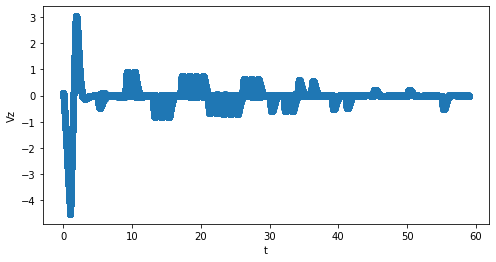

In [7]:
fig = plt.figure(figsize=(8, 4))
t = states_duplicates['Time']
y = states_duplicates['Dz']
#y_ref = states_duplicates['uvz']
plt.scatter(t, y)
#plt.scatter(t, y_ref)
plt.ylabel('Vz')
plt.xlabel('t')

Text(0.5, 0, 't')

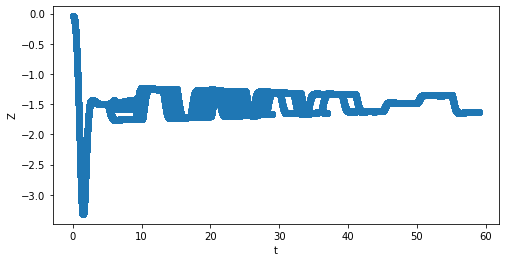

In [8]:
fig = plt.figure(figsize=(8, 4))
t = states_duplicates['Time']
y = states_duplicates['Z']
#y_ref = states_duplicates['uvz']
plt.scatter(t, y)
#plt.scatter(t, y_ref)
plt.ylabel('Z')
plt.xlabel('t')

### Se grafican los datos

Se grafica un histograma de cada una de las propiedades los datos analizados individualmente por columnas, en el cual se observa que todos tienen distribuciones altamente apuntadas (curosis) y en algunos casos bimodales, pero de cualquier manera, no son uniformes

In [9]:
n_bins = 50
#_ = dataset.hist(bins=n_bins, figsize=(30,30))

### Análisis de estados

Text(0.5, 0, 'Error Z')

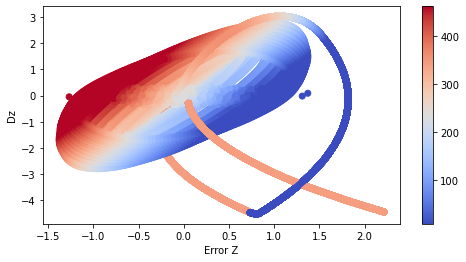

In [10]:
fig = plt.figure(figsize=(8, 4))
x = dataset['Z_r']-dataset['Z']
y = dataset['Dz']
c = dataset['Motor1']
plt.scatter(x, y, c=c, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Dz')
plt.xlabel('Error Z')

Text(0.5, 0, 'Z')

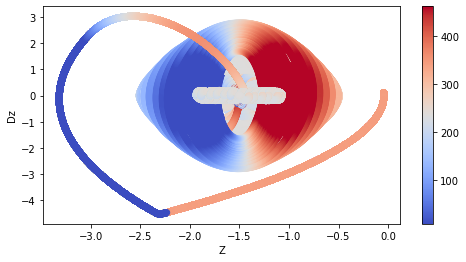

In [11]:
fig = plt.figure(figsize=(8, 4))
x = dataset['Z']
plt.scatter(x, y, c=c, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Dz')
plt.xlabel('Z')

Text(0.5, 0, 'Vz')

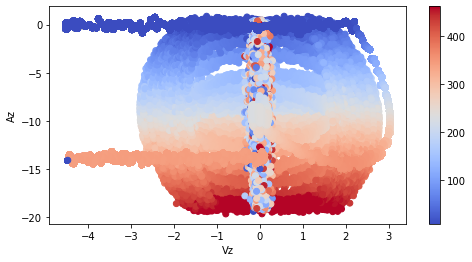

In [12]:
fig = plt.figure(figsize=(8, 4))
x = dataset['Dz']
y = dataset['Ac_Dz']
plt.scatter(x, y, c=c, cmap='coolwarm')
plt.colorbar()
plt.ylabel('Az')
plt.xlabel('Vz')

### Análisis de Fourier

#### Gráfica de algunas señales

In [13]:
def plot_fourier(df, states=['Z', 'Dz', 'Z_r']):
    dt = df['Time'][1]-df['Time'][0]
    n = len(df['Time'])
    Y = fft(df[states[0]].to_numpy()) / n # Transformada normalizada
    Y_ref = fft(df[states[1]].to_numpy()) / n
    frq = fftfreq(n, dt)
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(221)
    ax1.plot(df['Time'], df[states[0]], df['Time'], df[states[2]])
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('$y(t)$')
    ax1.set_title(f'Señal en el tiempo ({states[0]} y {states[2]})')
    ax2 = fig.add_subplot(223)
    ax2.set_title(f'Señal en frecuencia ({states[0]} y {states[2]})')
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y[0:int(n/10)]))
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y_ref[0:int(n/10)]),  color='orange')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Abs($Y$)')

    Y = fft(df[states[2]].to_numpy()) / n # Transformada normalizada
    ax1 = fig.add_subplot(222)
    ax1.plot(df['Time'], df[states[1]])
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('$y(t)$')
    ax1.set_title(f'Señal en tiempo ({states[1]})')
    ax2 = fig.add_subplot(224)
    ax2.set_title(f'Señal en frecuencia ({states[1]})')
    ax2.vlines(frq[0:int(n/10)], 0, abs(Y[0:int(n/10)]))
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Abs($Y$)')

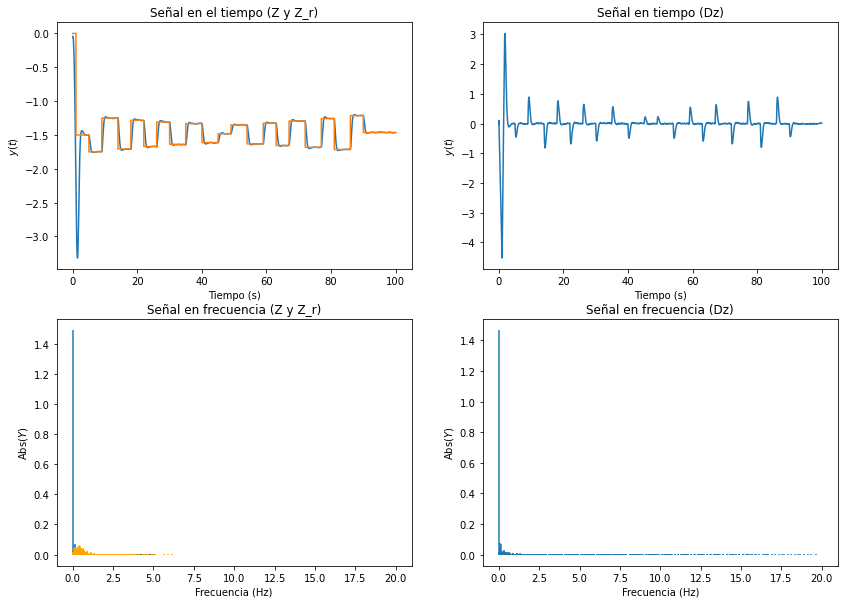

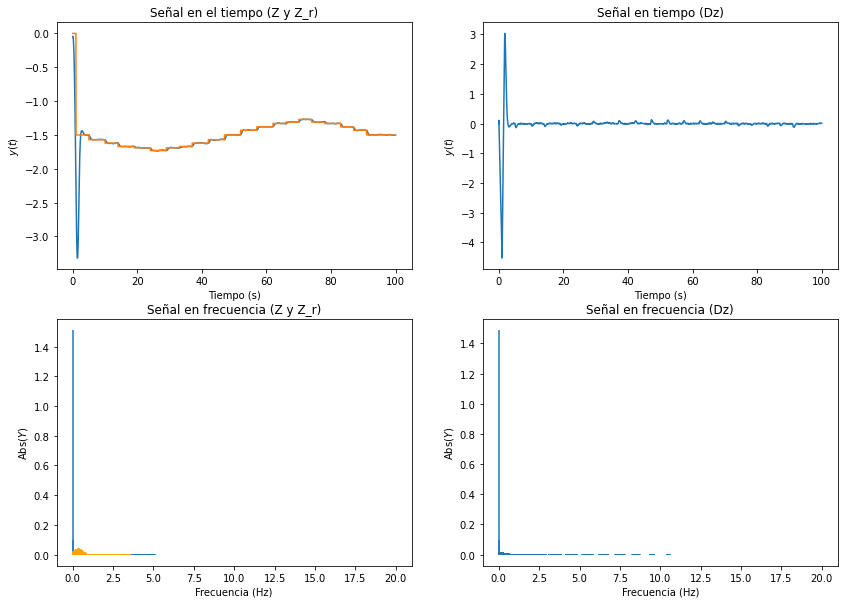

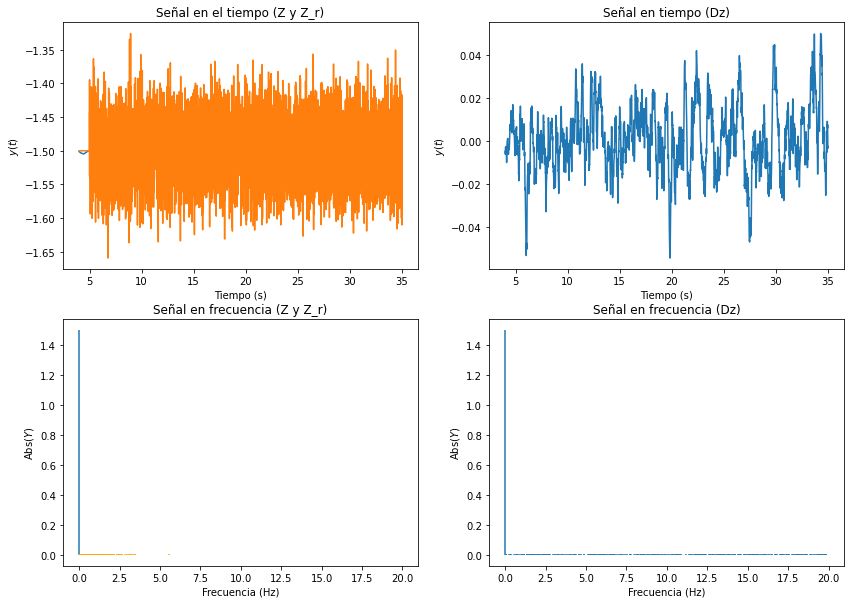

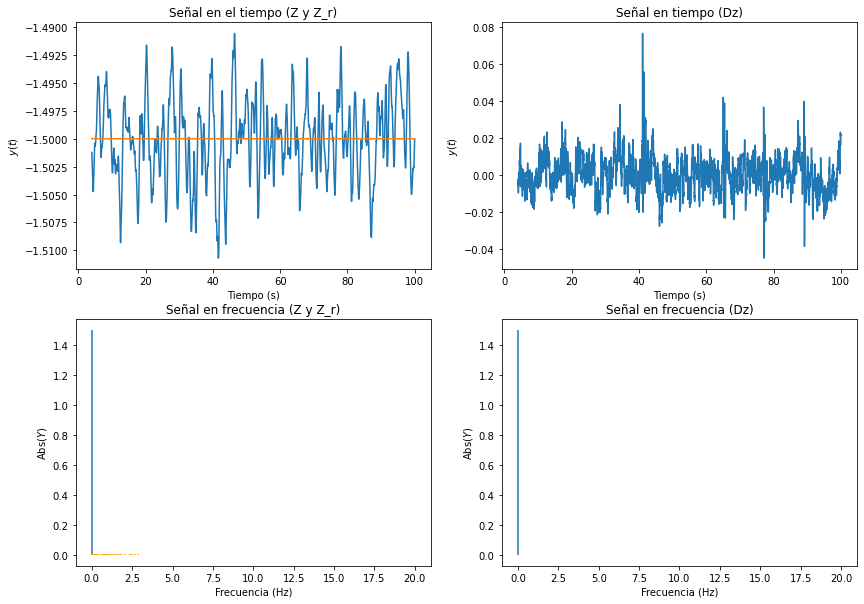

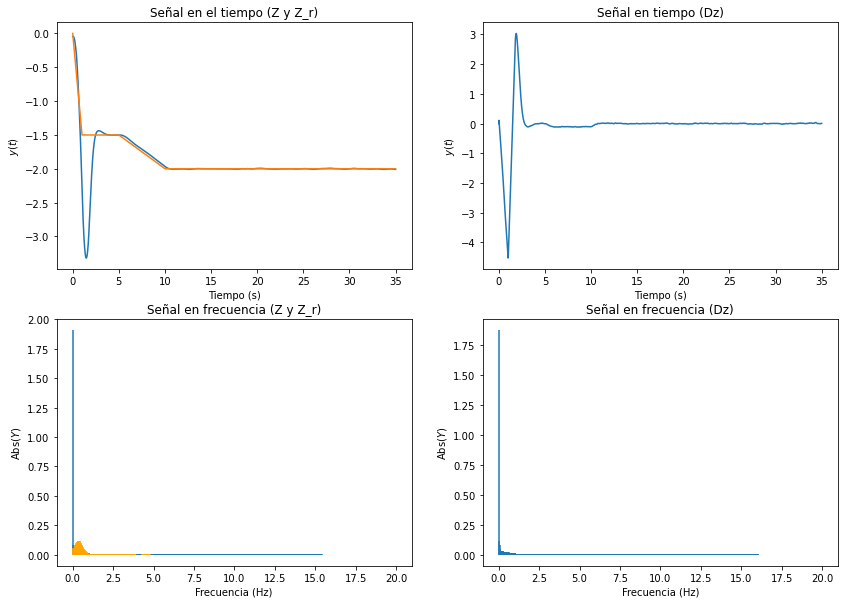

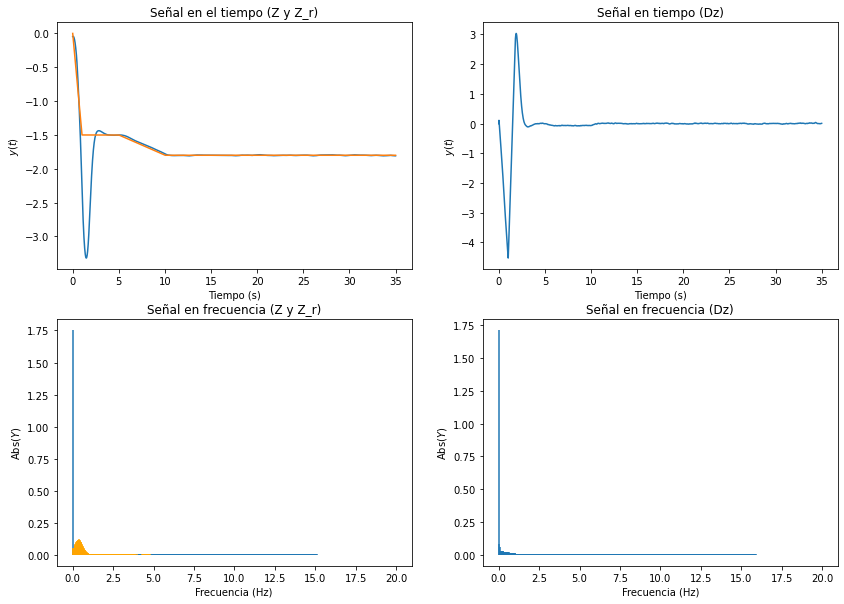

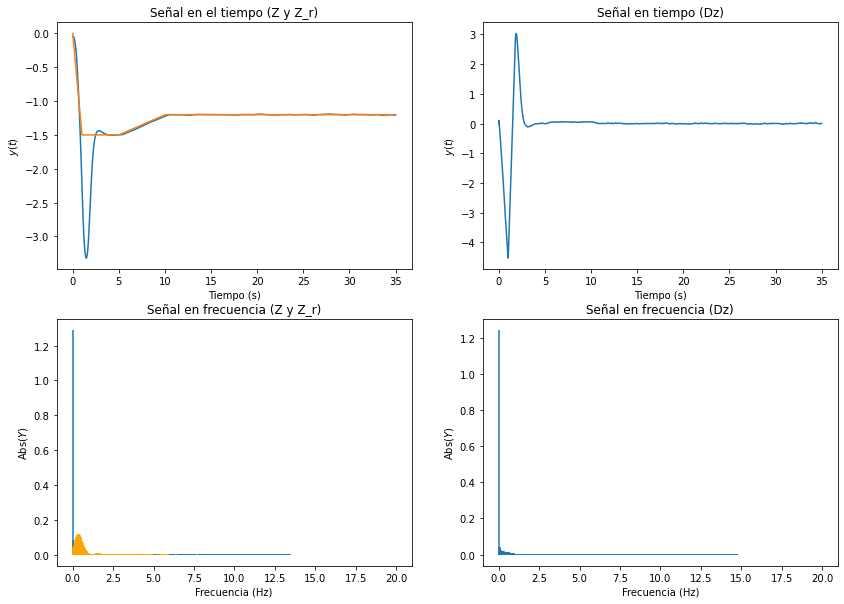

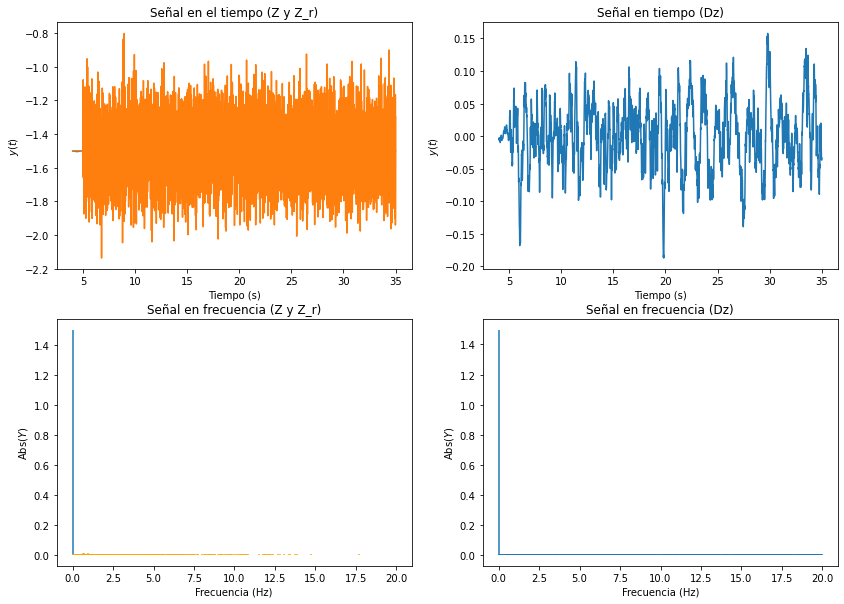

In [14]:
for df in random.choices(dfs, k = 8):
    plot_fourier(df)

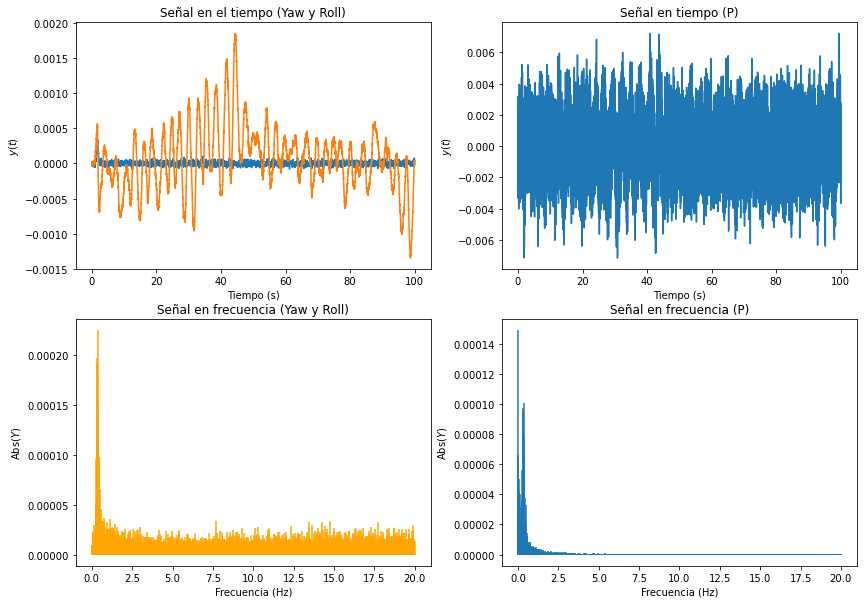

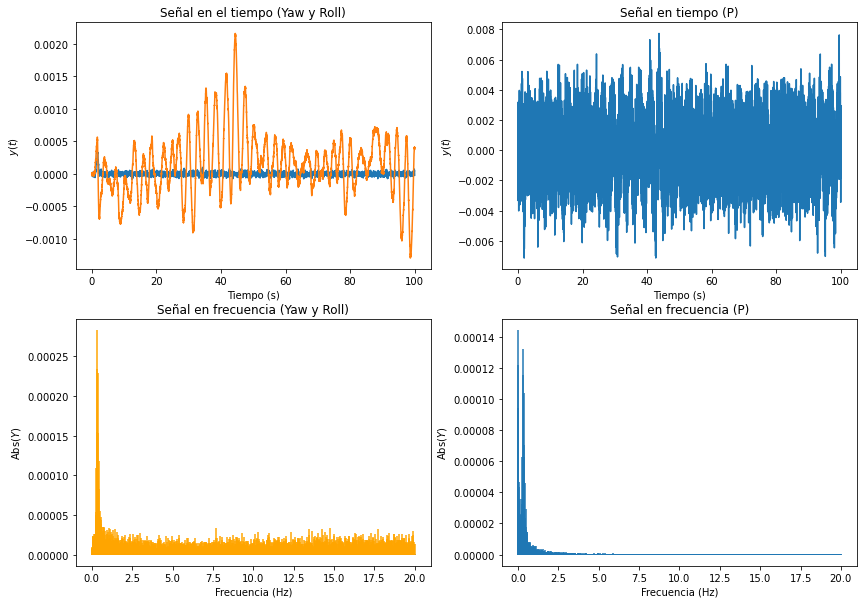

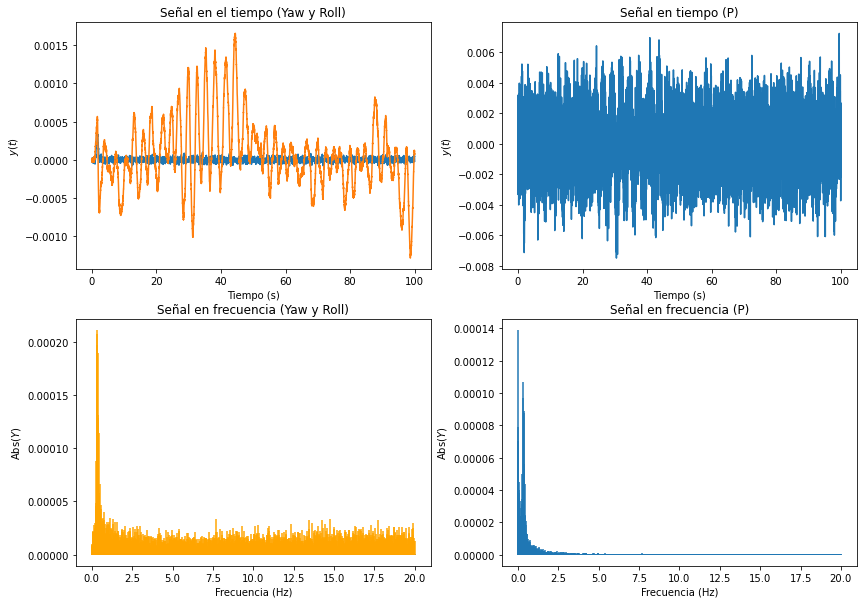

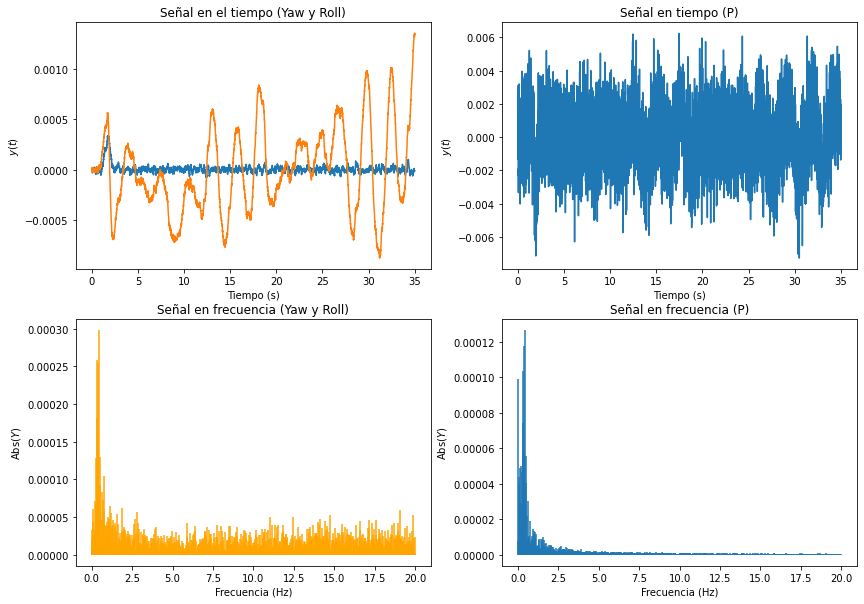

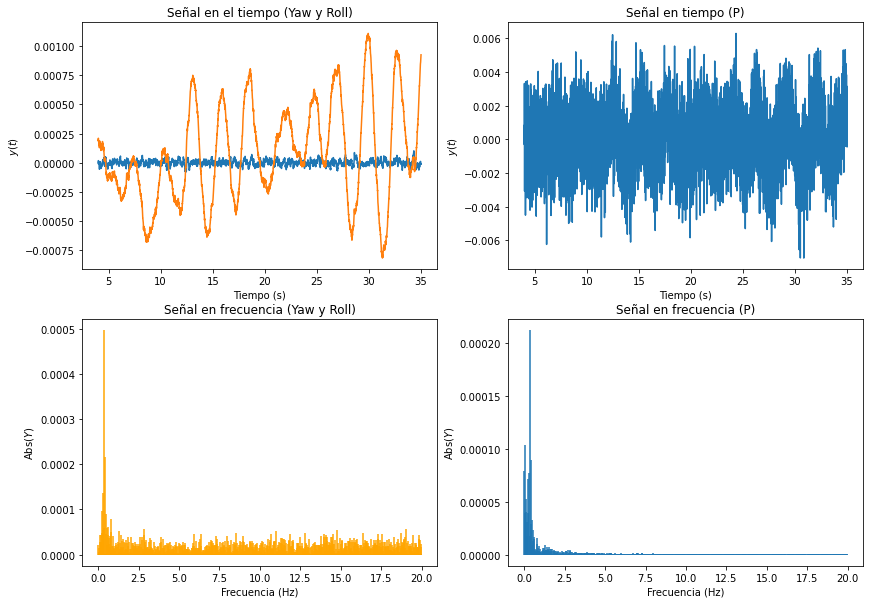

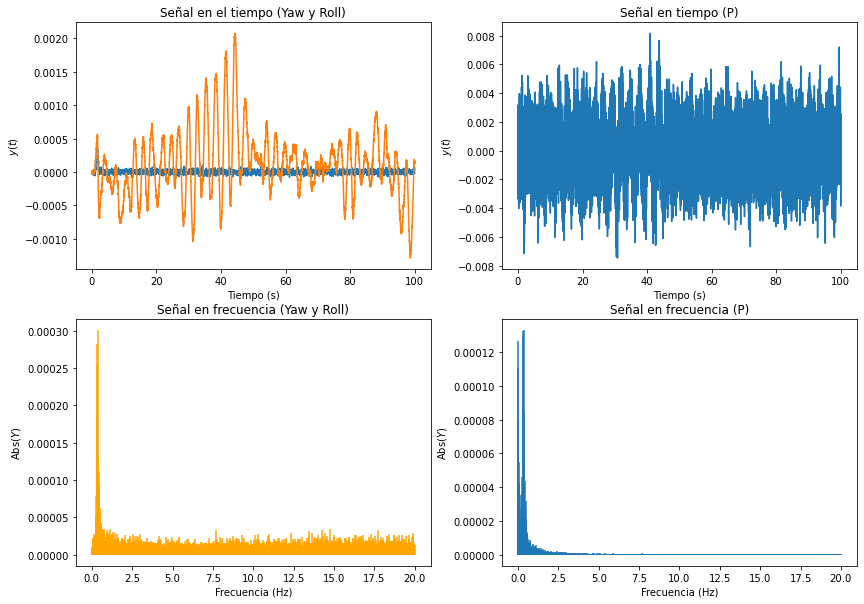

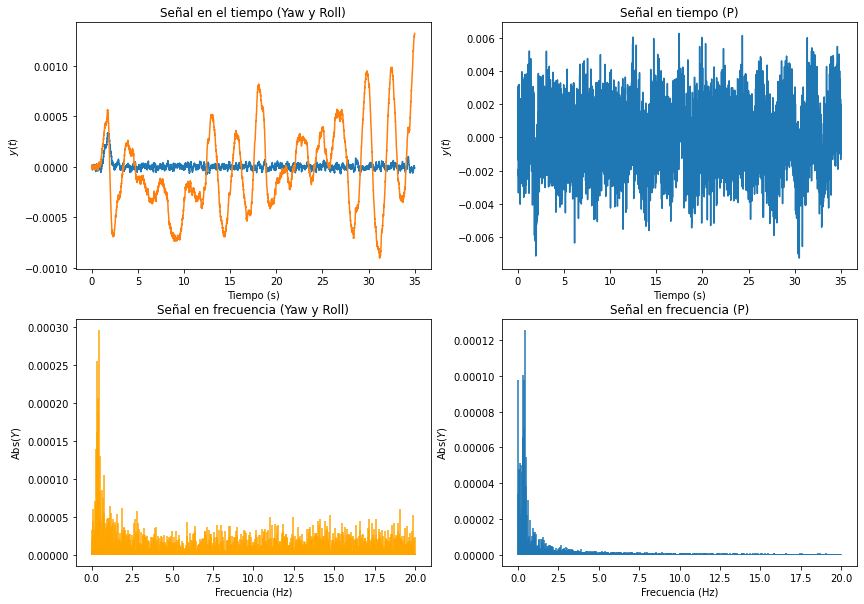

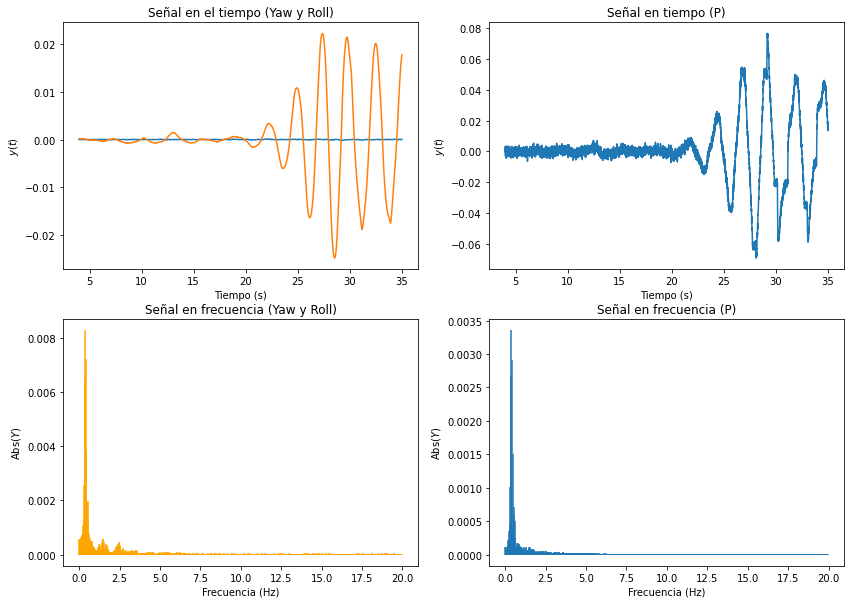

In [15]:
for df in random.choices(dfs, k = 8):
    plot_fourier(df, states=['Yaw', 'P', 'Roll'])

#### Histograma

In [16]:
Fourier = []
for i, df in enumerate(dfs):
    dt = df['Time'][1]-df['Time'][0]
    n = len(df['Time'])
    Fourier.append({})
    for state in states_list_org:
        Fourier[i][state]={}
        Fourier[i][state]['Y'] = abs(fft(df[state].to_numpy())/n)[0:int(n/2)] # Transformada normalizada
        Fourier[i][state]['X'] = fftfreq(n, dt)[0:int(n/2)]

In [17]:
F = {}
for state in states_list_org:
    F[state]={}
    F[state]['X'] = []
    F[state]['Y'] = []
    for f in Fourier:
        F[state]['X'] = np.concatenate([F[state]['X'], f[state]['X']]) 
        F[state]['Y'] = np.concatenate([F[state]['Y'], f[state]['Y']]) 

Text(0.5, 0, 'Frecuency [Hz]')

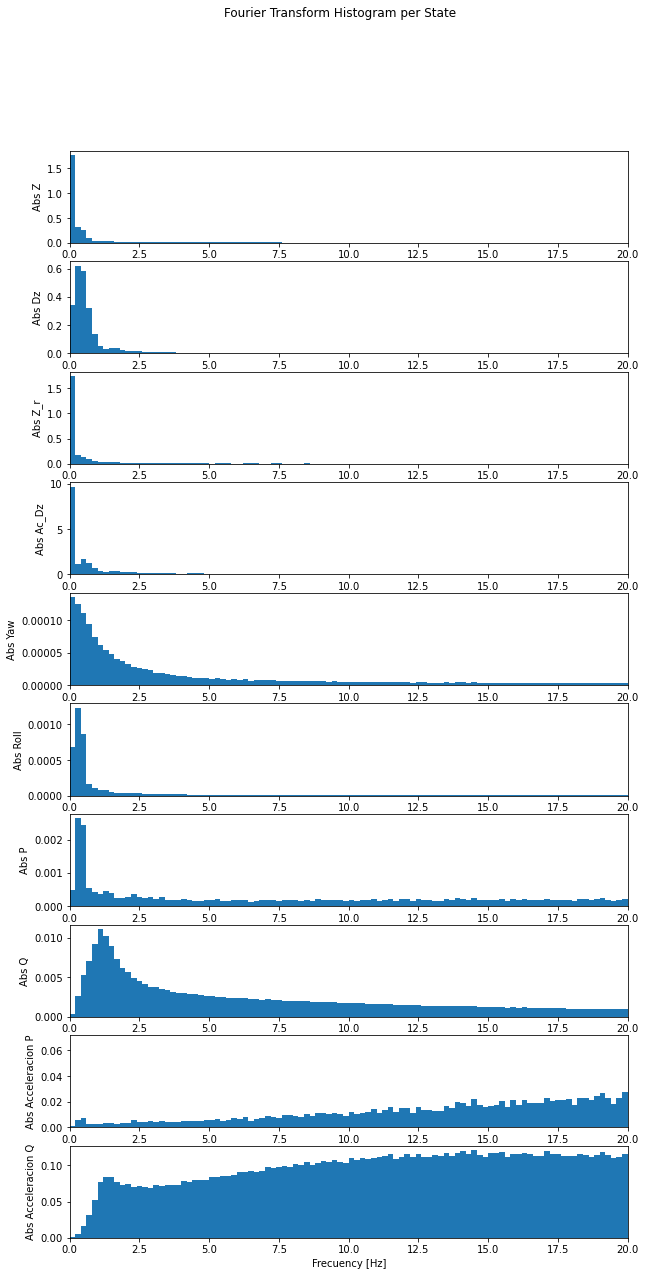

In [18]:
fig, axs = plt.subplots(len(states_list_org), 1, figsize=(10, 20))
fig.suptitle('Fourier Transform Histogram per State')
for i, state in enumerate(states_list_org):
    axs[i].hist(F[state]['X'], bins=10*n_bins, weights=((F[state]['Y']+1e-7)/len(Fourier)))
    axs[i].set_ylabel(f'Abs {state}')
    axs[i].set_xlim(0, 20)
axs[i].set_xlabel('Frecuency [Hz]')

### Análisis de Características - Método Estático

In [19]:
dataset.describe()

,Time,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,Motor1,Motor2,Motor3,Motor4,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,P_r,Q_r,R_r,Flag_Pitch_Roll,Ac_Dx,Ac_Dy,Ac_Dz,Gyro P,Gyro Q,Gyro R,Sonar Altitud,Pressure Altitud,Bat_V,Bat_Percentage,Acceleracion X,Acceleracion Y,Acceleracion Z,Acceleracion P,Acceleracion Q,Acceleracion R,Z1,Dz1,Z_r1,Ac_Dz1,Yaw1,Roll1,P1,Q1,Acceleracion P1,Acceleracion Q1,Z2,Dz2,Z_r2,Ac_Dz2,Yaw2,Roll2,P2,Q2,Acceleracion P2,Acceleracion Q2,Z3,Dz3,Z_r3,Ac_Dz3,Yaw3,Roll3,P3,Q3,Acceleracion P3,Acceleracion Q3
count,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1295895.0,1295895.0,1.295895e+06,1295895.0,1295895.0,1295895.0,1295895.0,1295895.0,1.295895e+06,1295895.0,1295895.0,1295895.0,1295895.0,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1295895.0,1295895.0,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06,1.295895e+06
mean,4.281013e+01,-3.350768e-04,-3.359317e-04,-1.503027e+00,2.256389e-06,7.887180e-05,-8.071778e-05,3.052208e-06,2.332470e-06,-1.521121e-02,1.573519e-06,1.412977e-06,-3.197492e-07,2.365206e+02,-2.365207e+02,2.365206e+02,-2.365208e+02,0.0,0.0,-1.482117e+00,0.0,0.0,0.0,0.0,0.0,-2.193838e-02,0.0,0.0,0.0,1.0,9.007334e-02,-5.992936e-02,-9.419827e+00,-9.498428e-03,-7.498578e-03,1.499741e-03,1.504551e+00,1.012529e+05,3.5,70.0,5.755633e-06,-1.250541e-04,-1.736796e-04,6.004077e-05,2.189152e-05,-8.116385e-06,-1.502918e+00,-1.521034e-02,-1.482007e+00,-9.419130e+00,2.257514e-06,7.887457e-05,1.273315e-06,1.303519e-06,1.038755e-05,-3.086813e-05,-1.502809e+00,-1.520958e-02,-1.481896e+00,-9.418387e+00,2.258437e-06,7.887883e-05,1.221378e-06,1.457860e-06,2.812219e-05,-7.125476e-06,-1.502699e+00,-1.520887e-02,-1.481784e+00,-9.417694e+00,2.258529e-06,7.888335e-05,1.080767e-06,1.493488e-06,2.985777e-06,-3.594663e-05
std,2.896393e+01,1.074610e-02,1.136344e-02,2.700165e-01,2.768997e-04,3.506121e-03,5.052975e-03,4.558698e-02,2.659362e-02,4.544270e-01,9.057596e-03,3.927625e-02,2.225740e-03,3.395921e+01,3.395556e+01,3.394866e+01,3.396455e+01,0.0,0.0,2.440522e-01,0.0,0.0,0.0,0.0,0.0,8.223455e+00,0.0,0.0,0.0,0.0,2.089574e-01,1.930278e-01,1.427087e+00,9.045007e-03,3.952919e-02,2.383690e-03,2.614817e-01,3.211676e+00,0.0,0.0,5.950564e-01,8.118001e-02,1.435704e+00,4.211311e-01,1.670874e+00,2.951463e-01,2.703173e-01,4.544223e-01,2.443724e-01,1.429272e+00,2.768997e-04,3.505640e-03,9.056365e-03,3.927625e-02,4.210900e-01,1.670862e+00,2.706177e-01,4.544177e-01,2.446916e-01,1.431431e+00,2.768996e-04,3.505148e-03,9.055216e-03,3.927624e-02,4.210710e-01,1.670856e+00,2.709177e-01,4.544130e-01,2.450097e-01,1.433600e+00,2.768996e-04,3.504645e-03,9.054026e-03,3.927624e-02,4.210606e-01,1.670853e+00
min,0.000000e+00,-3.573908e-01,-5.542104e-01,-3.318702e+00,-1.254526e-02,-1.588011e-01,-1.569786e-01,-1.510064e+00,-1.360795e+00,-4.524404e+00,-5.037703e-01,-3.575321e+00,-1.820346e-01,1.000000e+01,-4.613083e+02,1.000000e+01,-4.609848e+02,0.0,0.0,-2.774623e+00,0.0,0.0,0.0,0.0,0.0,-3.460435e+02,0.0,0.0,0.0,1.0,-8.013137e-01,-8.834900e-01,-1.963813e+01,-5.125701e-01,-3.605846e+00,-1.798834e-01,4.400000e-01,1.012314e+05,3.5,70.0,-8.899236e+01,-4.018375e+00,-1.017578e+01,-8.605778e+00,-1.592394e+02,-8.434417e+00,-3.318702e+00,-4.524404e+00,-2.774623e+00,-1.963813e+01,-1.254526e-02,-1.588011e-01,-5.037703e-01,-3.575321e+00,-8.605778e+00,-1.592394e+02,-3.318702e+00,-4.524404e+00,-2.774623e+00,-1.963813e+01,-1.254526e-02,-1.588

#### Mapa de Correlación

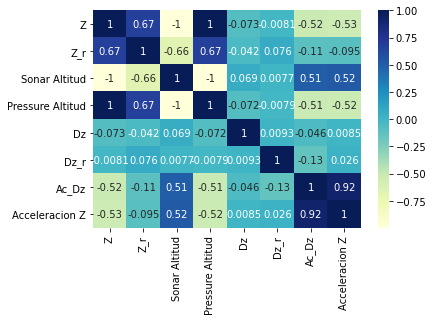

In [20]:
corr_states = ["Z", "Z_r", "Sonar Altitud", "Pressure Altitud",
              "Dz", "Dz_r", "Ac_Dz", "Acceleracion Z"]
correlation = dataset[corr_states].corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()

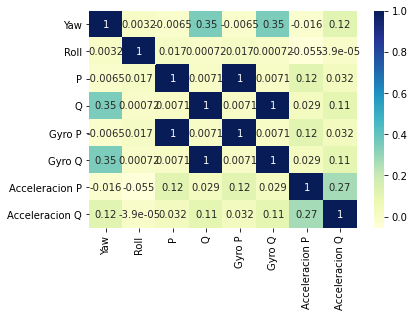

In [21]:
corr_states = ["Yaw", "Roll", "P", "Q",
               "Gyro P", "Gyro Q", 
              "Acceleracion P", "Acceleracion Q"]
correlation = dataset[corr_states].corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()